## Advanced Lane Finding Project

### The Project
---
The goals/steps of this project are the following:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a threshold binary image.
4. Apply a perspective transform to rectify binary image ("bird-eye-view").
5. Detect lane pixels and fit to the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import cv2

%matplotlib inline

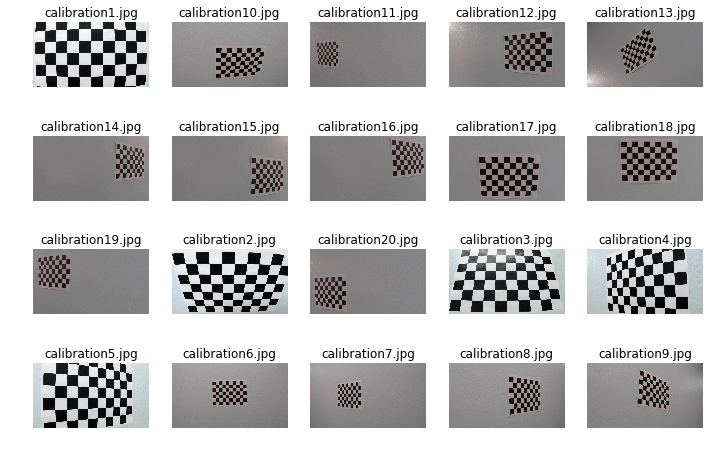

In [2]:
# Read in and make a list of calibration images
# Show all the images for caliration
images = glob.glob('./camera_cal/calibration*.jpg')

ncols = 5
nrows = int(len(images)/ncols)

plt.figure(figsize=(12, 8))
idx = 1

for fname in sorted(images):
    img = cv2.imread(fname)
    plt.subplot(nrows, ncols, idx)
    plt.axis('off')
    plt.title(fname.split('/')[-1])
    plt.imshow(img)
    idx += 1

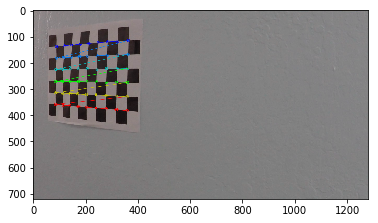

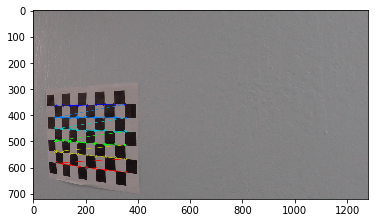

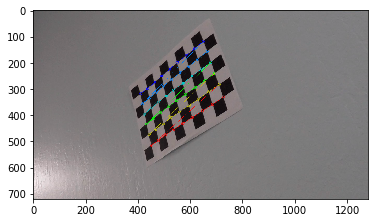

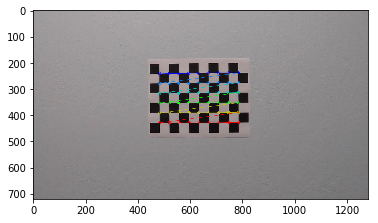

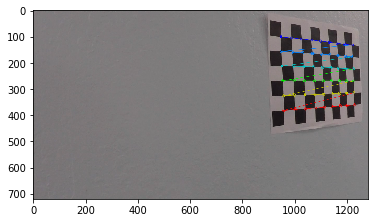

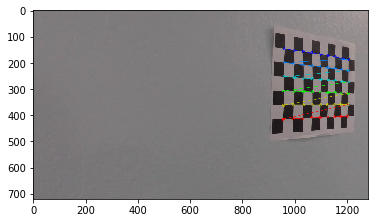

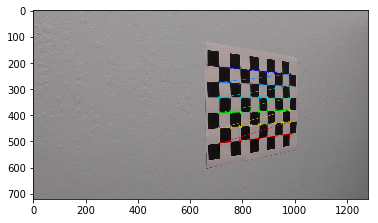

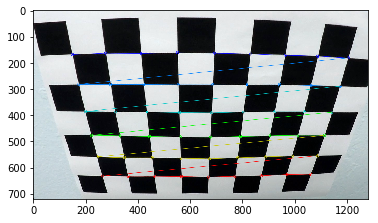

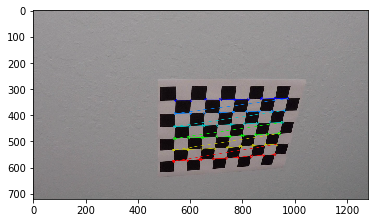

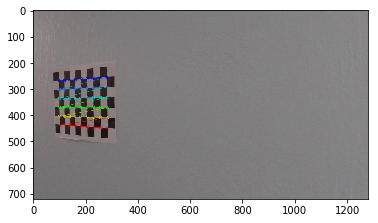

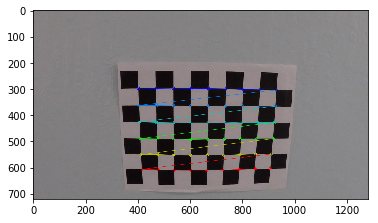

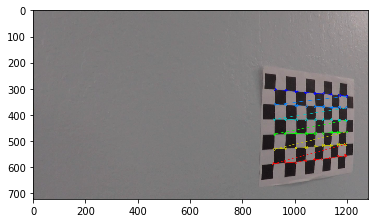

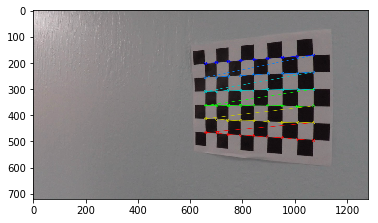

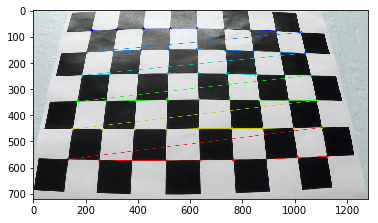

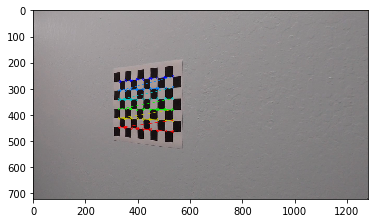

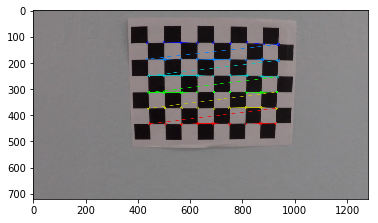

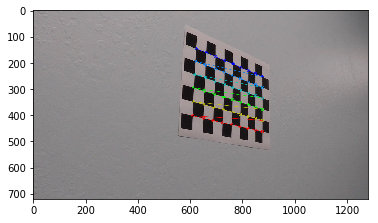

In [3]:
# Array to store
objpoints = []   # 3D points in real world space
imgpoints = []   # 2D points in image plane

# Prepare object points, like (0, 0, 0), (1,0,0), (),...(8,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)     # x, y coordinates

images = glob.glob('./camera_cal/calibration*.jpg')
for fname in images:
    # read in each image
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    
    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
    
    # if corners are found, add objects points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # draw and display the corners
        img = cv2.drawChessboardCorners(img,(9,6), corners, ret)
        plt.figure()
        plt.imshow(img)
        
# Camera calibration, given object points, image points, and the shape of the grayscale image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

### 2. Apply a distortion correction to raw images.

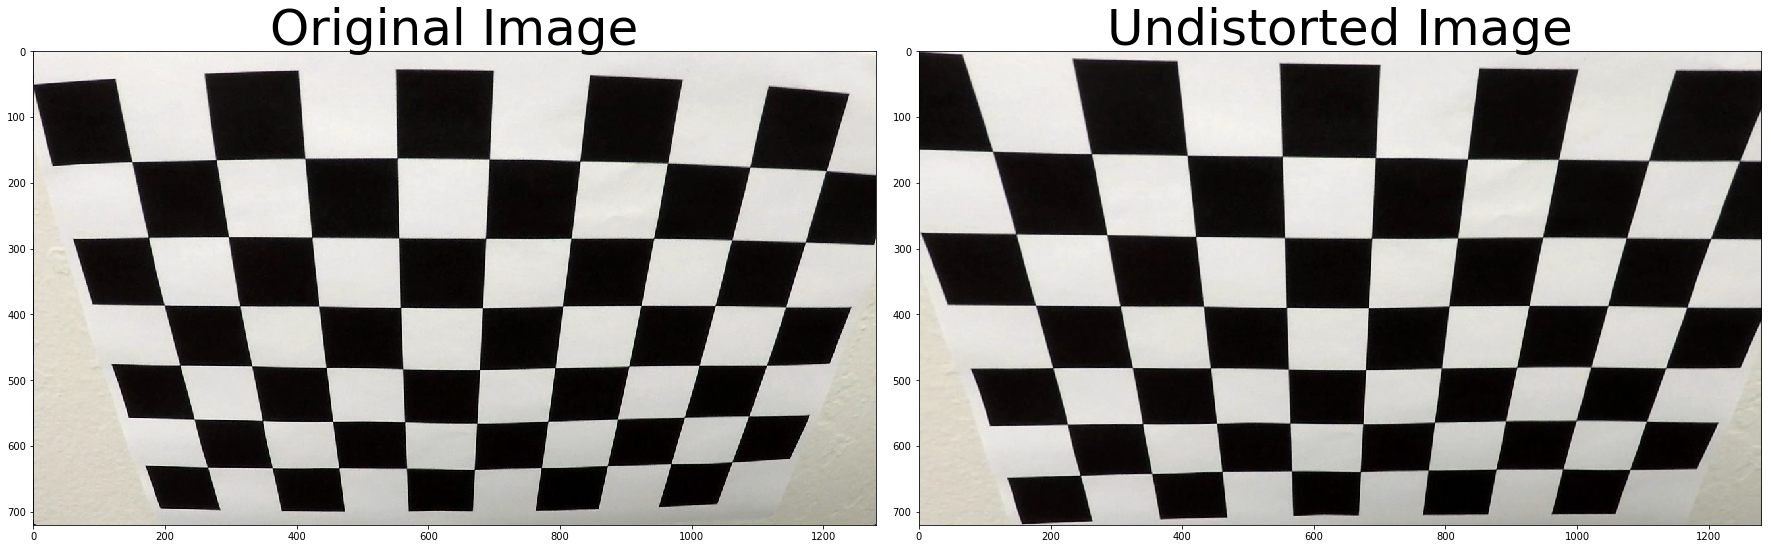

In [4]:
def undistort_image(img):
    # Undistort a test image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    return img

# Show a result
image_file = './camera_cal/calibration2.jpg'
img = cv2.imread(image_file)
img = img[...,::-1]  # RGB -> BGR
undistorted = undistort_image(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Original Image', fontsize=50)
ax1.imshow(img)
ax2.set_title('Undistorted Image', fontsize=50)
ax2.imshow(undistorted)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
# Apply undistort_image() function to images in camera_cal and test_images folders
# and save the results to output_images folder
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # apply undistort image
    dst = undistort_image(img)
    
    # save the results
    bgr_img = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
    cv2.imwrite("./output_images/camera_cal_output/" + "undistorted_cal" + str(idx+1) + ".jpg", bgr_img)

image_test = glob.glob('./test_images/test*.jpg')
for idx, fname in enumerate(image_test):
    img = cv2.imread(fname)
    img =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # apply undistort image
    dst = undistort_image(img)
    
    # save the results
    bgr_img = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
    cv2.imwrite("./output_images/test_images_output/" + "undistorted_test" + str(idx+1) + ".jpg", bgr_img)

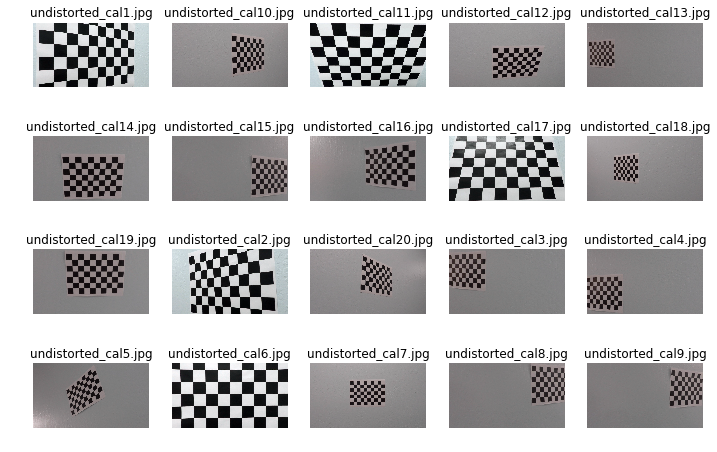

In [6]:
# Visualizing the undistorted images in camera_cal
results = glob.glob('./output_images/camera_cal_output/*.jpg')

ncols = 5
nrows = int(len(results)/ncols)

plt.figure(figsize=(12, 8))
idx = 1
for fname in sorted(results):
    rs = cv2.imread(fname)
    plt.subplot(nrows, ncols, idx)
    plt.axis('off')
    plt.title(fname.split('/')[-1])
    plt.imshow(rs)
    idx += 1

### 3. Use color transforms, gradients, etc., to create a threshold binary image.

Thresholded Binary


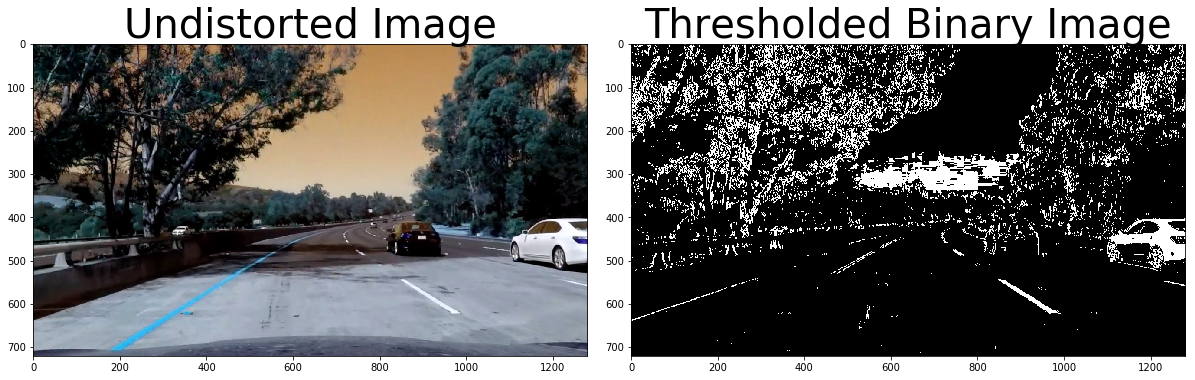

In [7]:
from utils.thresholds import *

# Plot the result
print("Thresholded Binary")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()

img3= cv2.imread('./output_images/test_images_output/undistorted_test1.jpg')
binary = toBinary(img3)

ax1.imshow(img3)
ax1.set_title('Undistorted Image', fontsize=40)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Thresholded Binary Image', fontsize=40)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

### 4. Apply a perspective transform to rectify binary image ("bird-eye-view")

Top down image


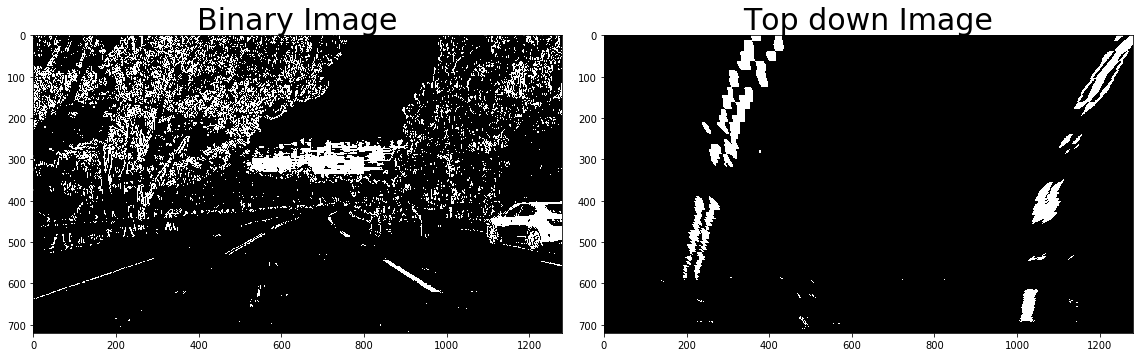

In [8]:
def warper(image):
    
    # offset for dst points
    offset = 350
    
    # Source points
    src = np.float32([[[ 610,  450]], 
                      [[ 680,  450]], 
                      [[ img_size[0]-300,  680]],
                      [[ 380,  680]]])

    # Result points        
    dst = np.float32([[offset, 0], 
                    [img_size[0]-offset, 0], 
                    [img_size[0]-offset, img_size[1]], 
                    [offset, img_size[1]]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    
    # Return the resulting image and matrix
    return warped, M
    
warped, perspective_M = warper(binary)

print('Top down image')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Binary Image", fontsize=30)
ax1.imshow(binary, cmap='gray')
ax2.set_title("Top down Image", fontsize=30)
ax2.imshow(warped, cmap='gray')

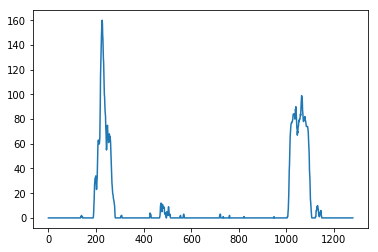

In [9]:
# Take a histogram of the bottom half of the image
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
plt.plot(histogram);

### 5. Detect lane pixels and fit to the lane boundary

Left and right points
Left:  [214.0, 208.0, 225.0, 241.0, 243.0, 293.0, 309.0, 326.0, 354.0]
Right:  [1031.0, 1025.0, 1045.0, 1064.0, 1075.0, 1127.0, 1164.0, 1197.0, 1245.0]

Fitted image


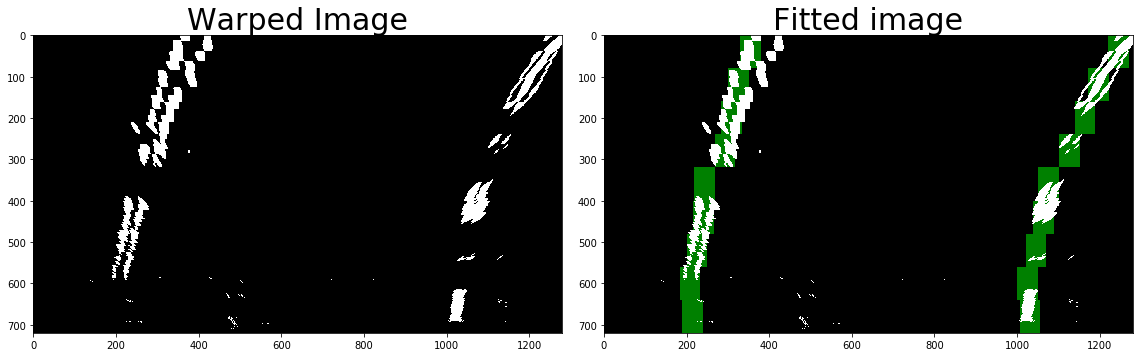

In [10]:
# Read in a thresholded image
# warped = mpimg.imread(warped)

# Window settings
window_width = 50
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100       # How much to slide left and right for searching

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    leftx = []
    rightx = []
    
    window = np.ones(window_width) # Create our window template that we will use for convolutions   
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))  
    leftx.append(l_center)
    rightx.append(r_center)
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        prev_l_center = l_center        
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        prev_r_center = r_center
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        leftx.append(l_center)
        rightx.append(r_center)

    return window_centroids, leftx, rightx

window_centroids, leftx, rightx = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results    
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    out_img = np.dstack((warped, warped, warped))*255
    warpage = np.array(out_img,np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
print('Left and right points')
print ('Left: ',leftx)
print ('Right: ',rightx)
print('')
print('Fitted image')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Warped Image", fontsize=30)
ax1.imshow(warped, cmap='gray')
ax2.set_title("Fitted image", fontsize=30)
ax2.imshow(output)  

### 6. Determine the curvature of the lane and vehicle position with respect to center

Left: 856.062470926 m - Right: 428.138913493 m


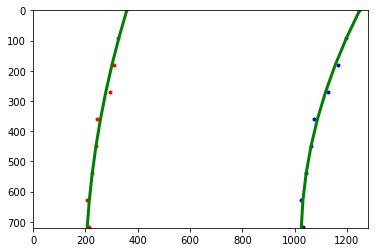

In [11]:
# to cover same y-range as image
ploty = np.linspace(0, 719, num=9)

def curvature(leftx, rightx):
    leftx = np.asarray(leftx[::-1])  # Reverse to match top-to-bottom in y
    rightx = np.asarray(rightx[::-1])  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    position = ((rightx_int+leftx_int)/2)-50
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return position, center, leftx, rightx, left_fitx, right_fitx, left_curverad, right_curverad

position, center, leftx, rightx, left_fitx, right_fitx, left_curverad, right_curverad = curvature(leftx, rightx)

# Plot up the data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Now our radius of curvature is in meters
print('Left:',left_curverad, 'm - Right:', right_curverad, 'm')

### 7. Warp the detected lane boundaries back onto the original image. 

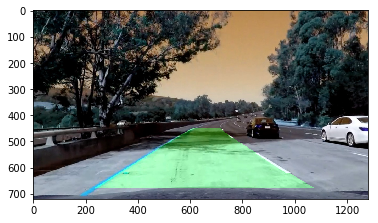

In [12]:
def warpBack(image, warp, persp_M, le_fitx, ri_fitx):
    Minv = np.linalg.inv(persp_M)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([le_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([ri_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

plt.imshow(warpBack(img3, warped, perspective_M, left_fitx, right_fitx))

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

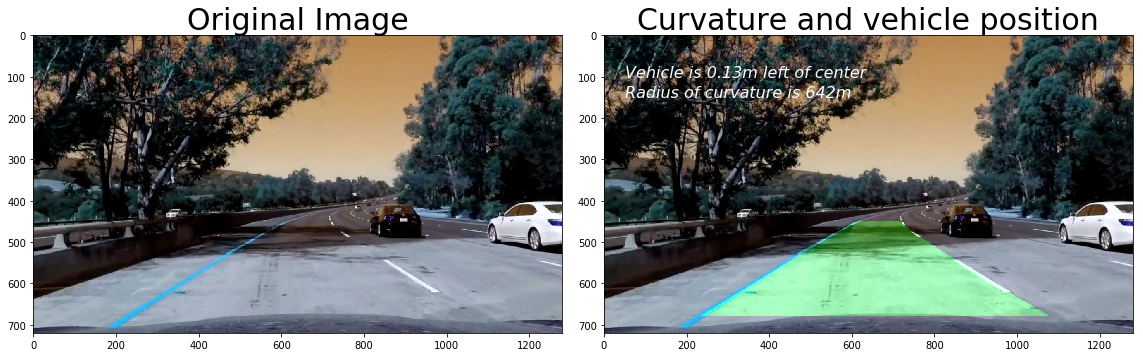

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Original Image", fontsize=30)
ax1.imshow(img3)
ax2.set_title("Curvature and vehicle position", fontsize=30)

if position == 640:
    ax2.text(50, 100, 'Vehicle is in the center', style='italic', color='white', fontsize=16)
elif position < 640:
    ax2.text(50, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
         style='italic', color='white', fontsize=16)
else:
    ax2.text(50, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
         style='italic', color='white', fontsize=16)

ax2.text(50, 150, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)), 
         style='italic', color='white', fontsize=16)

ax2.imshow(warpBack(img3, warped, perspective_M, left_fitx, right_fitx))

### 9. The Final Pipeline

Test Lane Finding Algorithm


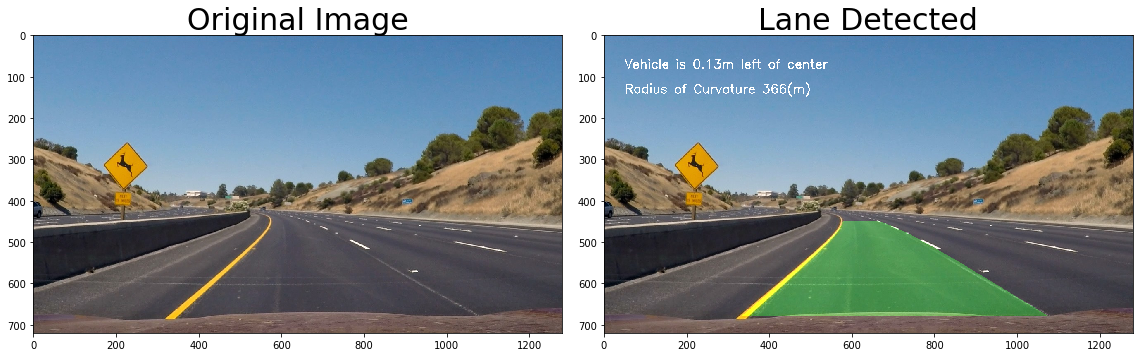

In [14]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
              
def lane_finding(img):  
    undistorded = undistort_image(img)
    final_binary = toBinary(undistorded)
    final_warped, final_perspective_M = warper(final_binary)
    window_cent, lex, rix = find_window_centroids(final_warped, window_width, window_height, margin)      
    position, center, leftx, rightx, left_lane.recent_xfitted, right_lane.recent_xfitted, left_lane.radius_of_curvature, right_lane.radius_of_curvature = curvature(lex, rix)

    alpha = 0.5
    if left_lane.bestx == None:
        left_lane.bestx = left_lane.recent_xfitted
    else :    
        left_lane.recent_xfitted = left_lane.recent_xfitted * ( 1 - alpha) + alpha * left_lane.bestx
        
    if right_lane.bestx == None:
        right_lane.bestx = right_lane.recent_xfitted
    else :    
        right_lane.recent_xfitted = right_lane.recent_xfitted * ( 1 - alpha) + alpha * right_lane.bestx  
            
    #Sanity check  
    left_lane.detected = False
    right_lane.detected = False 
    
    max_distance = 0  
    min_distance = 10000
    for i in range(len(left_lane.recent_xfitted)) : 
        point_distance = right_lane.recent_xfitted[i] - left_lane.recent_xfitted[i]
        if point_distance > max_distance:
            max_distance = point_distance
        if point_distance < min_distance:
            min_distance = point_distance    
        
    if (min_distance > 710) and (max_distance < 900):
        left_lane.detected = True
        right_lane.detected = True              
        
    if not left_lane.detected:
        left_lane.recent_xfitted = left_lane.bestx
    else:
        left_lane.bestx = left_lane.recent_xfitted
    if not right_lane.detected:
        right_lane.recent_xfitted = right_lane.bestx
    else:
        right_lane.bestx = right_lane.recent_xfitted
    
    result = warpBack(img, final_warped, final_perspective_M, left_lane.recent_xfitted, right_lane.recent_xfitted)    
    
    # Print the distances from center on video
    if (center*3.7/700) < 0.01:
        cv2.putText(result, 'Vehicle is in the center', (50,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    elif center < 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700), (50,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700), (50,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
    # Print the radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_lane.radius_of_curvature + right_lane.radius_of_curvature)/2)), (50,140),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
    return result

# Lane Finding 
print('Test Lane Finding Algorithm')
left_lane = Line()
right_lane = Line()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Original Image", fontsize=30)
ax1.imshow(img)
ax2.set_title("Lane Detected", fontsize=30)
ax2.imshow(lane_finding(img))

### 10. Test on The Project Video

In [15]:
# Import everything needed to edit/save/watch the video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_lane = Line()
right_lane = Line()
video_output = "project_video_result.mp4"
input_video = VideoFileClip("../CarND-Advanced-Lane-Lines/project_video.mp4")
output = input_video.fl_image(lane_finding)
%time output.write_videofile(video_output, audio = False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [02:20<00:00,  7.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 5min 27s, sys: 3min 21s, total: 8min 49s
Wall time: 2min 21s
